# Executive Summary

My recommendation for manager is to adopt capacity rationing pricing. The new policy has a 50.6% increase in gain. Please note that the figure varies on the result of customer simulation, but generally rationing pricing gives the company a better return.
#### Result:
Constant Pricing Policy:
optimal p: 245, expected profit: 2544.9
<br> Dynamic Pricing Policy
optimal p1:235 , optimal p2:310, expected profit: 3246.55
<br> Capacity Rationing Pricing Policy
optimal p1:230 , optimal p2:330, optimal 30: ,expected profit: 3833.6

#### Recommendation: Adopt capacity rationing pricing policy and it is estimated that there is 50.6% increase in profit.

# Generating Customers

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

In [2]:
def generateCustomers():
    #np.random.seed(42)
    # Leisure customers
    sizeL = int(norm(200,60).rvs())
    if sizeL < 0:
        sizeL = 0
    LeisureTime = np.random.uniform(low=0,high=181,size=sizeL)
    LeisurePay = norm(200,80).rvs(sizeL)
    
    # Business customers
    sizeB = int(norm(60,20).rvs())
    BusinessTime = np.random.uniform(low=0,high=15,size=sizeB)
    BusinessPay = norm(350,120).rvs(sizeB)
    
    # concatenate 
    arrival_time = np.concatenate([LeisureTime, BusinessTime])
    valuation = np.concatenate([LeisurePay,BusinessPay])
    
    # create dataframe
    df = pd.DataFrame({'arrival_time':arrival_time,
                      'valuation':valuation}).sort_values('arrival_time',ascending=False)
    df.reset_index(inplace=True)
    df = df.iloc[:,1:]
    
    return df

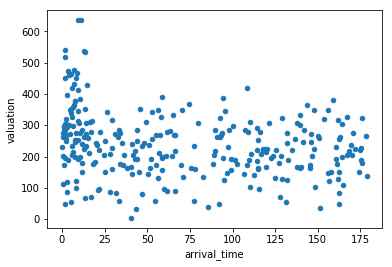

In [9]:
np.random.seed(42)
generateCustomers().plot(x='arrival_time',y='valuation',kind='scatter')

# Simulating Pricing Policies

In [10]:
def simulateConstant(customers,seats,p):
    temp = customers[customers['valuation']>=p]
    
    if temp.shape[0] < seats:
        return temp.shape[0]*p
    else:
        return seats * p

In [11]:
def simulateDynamic(customers,seats,p1,p2):
    temp = customers[customers['valuation']>=p1]
    
    if temp[temp['arrival_time'] > 14].shape[0] > seats:
        return seats * p1
    
    else:
        r1 = temp[temp['arrival_time'] > 14].shape[0] * p1
        seatsLeft = seats - temp[temp['arrival_time'] > 14].shape[0]
        temp = temp[(temp['arrival_time'] <= 14)&(temp['valuation']>=p2)]
        if temp.shape[0]<seatsLeft:
            r2 = temp.shape[0] * p2
        else:
            r2 = seatsLeft * p2
        
        
        return r1 + r2

In [12]:
def simulateRationing(customers,seats,p1,p2,l):
    temp = customers[customers['valuation']>=p1]
    
    if temp.shape[0] >= seats:
        r1 = (seats - l) * p1
        temp = temp[temp['valuation']>=p2]
        if temp.shape[0] >= l:
            r2 = l * p2
        else:
            r2 = temp.shape[0] * p1
        
        return r1+r2
    
    else:
        if temp.shape[0] <= seats - l:
            return temp.shape[0] * p1
        else:
            r1 = (temp.shape[0]-l)*p1
            temp = temp.iloc[(seats-l):,:]
            temp = temp[temp['valuation']>=p2]
            r2 = temp.shape[0] * p2
            return r1 + r2

In [13]:
data=[[170,50],[150,40],[13,95],[12,100]]
customers=pd.DataFrame(data,columns=['arrival_time','valuation'])
print('Constant policy with 2 seats p=50 \t:',simulateConstant(customers,2,50))
print('Constant policy with 2 seats p=100 \t:',simulateConstant(customers,2,100))
print('Dynamic policy with 3 seats p1=40, p2=95 \t:',simulateDynamic(customers,3,40,95))
print('Dynamic policy with 2 seats p1=40, p2=95 \t:',simulateDynamic(customers,2,40,95))
print('Dynamic policy with 1 seats p1=50, p2=100 \t:',simulateDynamic(customers,1,50,100))
print('Rationing policy with 3 seats p1=40, p2=100, l=1 \t:',\
        simulateRationing(customers,3,40,100,1))
print('Rationing policy with 2 seats p1=40, p2=100, l=1 \t:',\
        simulateRationing(customers,2,40,100,1))
print('Rationing policy with 1 seats p1=40, p2=95, l=1 \t:',\
simulateRationing(customers,1,40,95,1))

Constant policy with 2 seats p=50 	: 100
Constant policy with 2 seats p=100 	: 100
Dynamic policy with 3 seats p1=40, p2=95 	: 175
Dynamic policy with 2 seats p1=40, p2=95 	: 80
Dynamic policy with 1 seats p1=50, p2=100 	: 50
Rationing policy with 3 seats p1=40, p2=100, l=1 	: 180
Rationing policy with 2 seats p1=40, p2=100, l=1 	: 140
Rationing policy with 1 seats p1=40, p2=95, l=1 	: 95


# Optimizing Parameters

In [17]:
dfs = []
for i in range(100):
    df = generateCustomers()
    dfs.append(df)

In [18]:
p1s = range(230,260,5)
p2s = range(290,340,5)

###  Constant Pricing

In [19]:
revenues1 = np.empty((len(dfs),len(p1s)))
for i,df in enumerate(dfs):
    for j, p1 in enumerate(p1s):
        revenues1[i][j] = simulateConstant(df,100,p1)

In [20]:
profit = np.mean(revenues1,axis=0)-20000
profit_best_1 = max(profit)
p1_best_1 = p1s[np.argmax(profit)]
print('Constant price policy: best p =',p1_best_1,'best expected profit =',profit_best_1)

Constant price policy: best p = 245 best expected profit = 2544.9000000000015


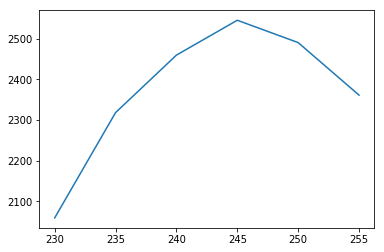

In [21]:
plt.plot(p1s,profit)

### Dynamic Pricing

In [22]:
revenues2 = np.empty((len(p1s),len(p2s)))
for i,p1 in enumerate(p1s):
    for j,p2 in enumerate(p2s):
        temp = []
        for df in dfs:
            temp.append(simulateDynamic(df,100,p1,p2))
        revenues2[i][j] = sum(temp)/len(temp)
        
profit_best_2=revenues2.max() - 20000
p1_best_2 = p1s[np.unravel_index(np.argmax(revenues2, axis=None), revenues2.shape)[0]]
p2_best_2 = p2s[np.unravel_index(np.argmax(revenues2, axis=None), revenues2.shape)[1]]
print('Dynamic price policy: best p1 =',p1_best_2,', best p2 =', p2_best_2,',best expected profit =',profit_best_2)

Dynamic price policy: best p1 = 235 , best p2 = 310 ,best expected profit = 3246.5499999999993


### Capacity Rationing Pricing

In [28]:
ls = range(25,35,1)
revenues3 = np.empty((len(p1s),len(p2s)))
profits = []
d = {}
for l in ls:
    for i,p1 in enumerate(p1s):
        for j,p2 in enumerate(p2s):
            temp2=[]
            for df in dfs:
                temp2.append(simulateRationing(df,100,p1,p2,l))
            revenues3[i][j] = sum(temp2)/len(temp2)
    p = revenues3.max() - 20000
        
    profits.append(p)  

l_best = ls[np.argmax(profits)]

In [29]:
profits[np.argmax(profits)],ls[np.argmax(profits)]

(3833.5999999999985, 30)

In [30]:
revenues4 = np.empty((len(p1s),len(p2s)))
for i,p1 in enumerate(p1s):
    for j,p2 in enumerate(p2s):
        temp = []
        for df in dfs:
            temp.append(simulateRationing(df,100,p1,p2,l_best))
        revenues4[i][j] = sum(temp)/len(temp)
        
profit_best_3 = profits[np.argmax(profits)]
p1_best_3 = p1s[np.unravel_index(np.argmax(revenues4, axis=None), revenues4.shape)[0]]
p2_best_3 = p2s[np.unravel_index(np.argmax(revenues4, axis=None), revenues4.shape)[1]]

print('Capacity rationing policy: best p1 =',p1_best_3,', best p2 =', p2_best_3,', best l = ', l_best,',best expected profit=',profit_best_3)

Capacity rationing policy: best p1 = 230 , best p2 = 330 , best l =  30 ,best expected profit= 3833.5999999999985


In [31]:
profit_best_3/profit_best_1-1

0.5063853196589243